# Fitting a Polynomial

In this tutorial, we will show how to use the generic curve fitting class `kontrol.curvefit.CurveFit` to fit a polynomial.

`kontrol.curvefit.CurveFit` is a low-level class for curve fitting. 
It uses optimization to minimize a cost function, e.g. mean squared error, to fit a curve.
It requires at least 5 specifications, 

* `xdata`: the independent variable data,
* `ydata`: the dependent variable data,
* `model`: The model,
* `cost`: the cost function, and
* `optimizer`: the optimization algorithm.

In addition, keyword arguments can be specified to the model and optimizer as `model_kwargs` and `optimizer_kwargs`.

The functions `model`, `cost`, and `optimizer` takes a specific format. See documentation or tutorial below on how to construct them, or simply use the predefined ones in `kontrol`.

Here, we will create the data to be fitted, which is a simple polynomial.

\begin{equation}
    y = \sum_{i=0} a_i x^i
\end{equation}

In [1]:
# Prepare the data
import numpy as np
import matplotlib.pyplot as plt


xdata = np.linspace(-1, 1, 1024)
np.random.seed(123)
random_args = np.random.random(5)*2 - 1  # Generate some random args to be fitted.
def polynomial(x, args, **kwargs):
    """
    Parameters
    ----------
    x : array
        x axis
    args : array
        A list of coefficients of the polynomial
    
    Returns
    -------
    array
        args[0]*x**0 + args[1]*x**1 ... args[len(args)-1]*x**(len(args)-1).
    """
    poly = np.sum([args[i]*x**i for i in range(len(args))], axis=0)
    return poly
ydata = polynomial(xdata, random_args)
print(random_args)

[ 0.39293837 -0.42772133 -0.54629709  0.10262954  0.43893794]


We see that the coefficients are

\begin{equation}
 a_i = \begin{bmatrix}0.39293837 & -0.42772133 & -0.54629709 &  0.10262954 & 0.43893794\end{bmatrix}
\end{equation}

Now let's see if we can recover it.

In [2]:
import kontrol.curvefit
import scipy.optimize

a = kontrol.curvefit.CurveFit()
a.xdata = xdata
a.ydata = ydata
a.model = polynomial

error_func = kontrol.curvefit.error_func.mse  ## Mean square error
a.cost = kontrol.curvefit.Cost(error_func=error_func)

# If we know the boundary of the coefficients,
# scipy.optimize.differential_evolution would be a suitable optimizer.
a.optimizer = scipy.optimize.differential_evolution
a.optimizer_kwargs = {"bounds": [(-1, 1)]*5, "workers": -1, "updating": "deferred"}  ## workers=1 will use all available CPU cores.
a.fit()
de_args = a.optimized_args
de_fit = a.yfit
print(de_args)

[ 0.39293837 -0.42772133 -0.54629709  0.10262954  0.43893794]


In [3]:
# If we know the inital guess instead,
# scipy.optimizer.minimize can be used.
# In this case, we choose the Powell algorithm.
# We also intentionally fit with 6th-order polynomial instead of 5th-order one.
a.optimizer = scipy.optimize.minimize
a.optimizer_kwargs = {"x0": [0]*6, "method": "Powell"}  ## Start from [0, 0, 0, 0, 0]
a.fit()
pw_args = a.optimized_args
pw_fit = a.yfit
print(pw_args)

[ 3.92938371e-01 -4.27721330e-01 -5.46297093e-01  1.02629538e-01
  4.38937940e-01 -5.90492751e-14]


In both cases we see the parameters are recovered well. Now let's look at some plots.

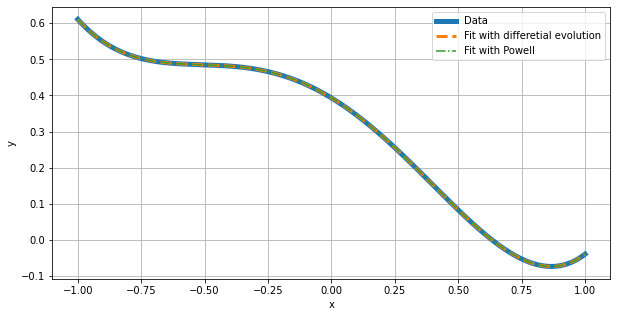

In [4]:
## Plot
plt.figure(figsize=(10, 5))
plt.plot(xdata, ydata, "-", label="Data", lw=5)
plt.plot(xdata, de_fit, "--", label="Fit with differetial evolution", lw=3)
plt.plot(xdata, pw_fit, "-.", label="Fit with Powell")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(which="both")